In [ ]:
from google.colab import files
files.upload()

! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c 'plant-pathology-2021-fgvc8'
! mkdir data


Saving kaggle.json to kaggle.json
100% 14.9G/14.9G [02:20<00:00, 124MB/s]
100% 14.9G/14.9G [02:20<00:00, 114MB/s]


In [ ]:
! unzip plant-pathology-2021-fgvc8.zip -d data

Streaming output truncated to the last 5000 lines.
  inflating: data/train_images/e00c97b2de4749ce.jpg  
  inflating: data/train_images/e00df890cfe62736.jpg  
  inflating: data/train_images/e00ed0bf43a87f25.jpg  
  inflating: data/train_images/e00f759d65d52887.jpg  
  inflating: data/train_images/e00f934d9e50ad5b.jpg  
  inflating: data/train_images/e00fce341cb63da5.jpg  
  inflating: data/train_images/e010c7c35ecf3d1c.jpg  
  inflating: data/train_images/e01112939f783fec.jpg  
  inflating: data/train_images/e01592da4d71b8be.jpg  
  inflating: data/train_images/e0189acaf8cf80fd.jpg  
  inflating: data/train_images/e0189e4999bdd0fa.jpg  
  inflating: data/train_images/e01ae16d4a759cb5.jpg  
  inflating: data/train_images/e01dc39ccb2b4ccb.jpg  
  inflating: data/train_images/e01e42d90c66f3f3.jpg  
  inflating: data/train_images/e01e870bec65f40f.jpg  
  inflating: data/train_images/e01f17e0187fb80f.jpg  
  inflating: data/train_images/e01f503cb752e6c5.jpg  
  inflating: data/train_images/

In [ ]:
img_path="/content/data"

In [ ]:
!pip install keras_preprocessing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.0 MB/s eta 0:00:00


In [ ]:
# Initial imports
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import cv2
import time
import random
import itertools
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style
import tensorflow_hub as hub

from PIL import Image
from datetime import datetime
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

In [ ]:
train_values = tf.io.gfile.glob(str(img_path + '/train_images/*'))
test_values = tf.io.gfile.glob(str(img_path + '/test_images/*'))

print(len(train_values))

18632


In [ ]:
train_data = pd.read_csv(r"/content/data/train.csv")
#test_data = pd.read_csv(r"/content/data/test.csv")
train_data.tail()

,image,labels
18627,fffb900a92289a33.jpg,healthy
18628,fffc488fa4c0e80c.jpg,scab
18629,fffc94e092a59086.jpg,rust
18630,fffe105cf6808292.jpg,scab frog_eye_leaf_spot
18631,fffe472a0001bd25.jpg,healthy


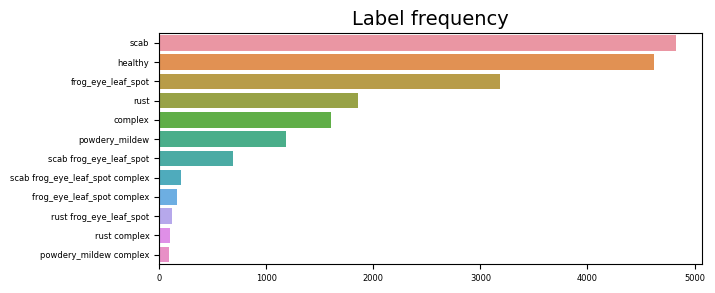

In [ ]:
label_freq = train_data['labels'].apply(lambda s: str(s)).explode().value_counts().sort_values(ascending=False)

# Bar plot
plt.figure(figsize=(7,3))
sns.barplot(y=label_freq.index.values, x=label_freq, order=label_freq.index)
plt.title("Label frequency", fontsize=14)
plt.xlabel("")
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.show()

In [ ]:
def split_label(x):
  return [i for i in str(x).split()]

train_data['all_labels'] = train_data['labels'].apply(lambda i: split_label(i))

train_data.head()

,image,labels,all_labels
0,800113bb65efe69e.jpg,healthy,[healthy]
1,8002cb321f8bfcdf.jpg,scab frog_eye_leaf_spot complex,"[scab, frog_eye_leaf_spot, complex]"
2,80070f7fb5e2ccaa.jpg,scab,[scab]
3,80077517781fb94f.jpg,scab,[scab]
4,800cbf0ff87721f8.jpg,complex,[complex]


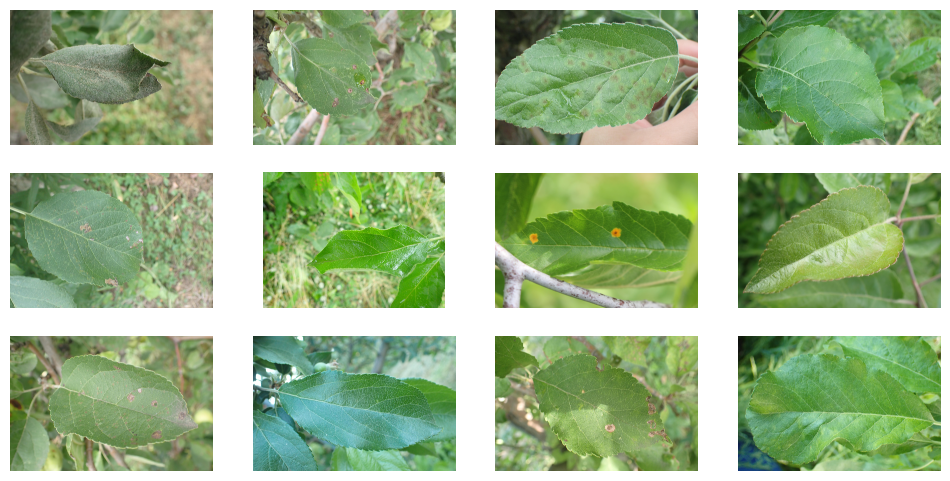

In [ ]:
train_paths = [os.path.join(img_path + "/train_images/", str(f)) for f in train_data['image']]
corresponding_labels = [f for f in train_data['all_labels']]

nobs = 14 # Maximum number of images to display
ncols = 4 # Number of columns in display
nrows = nobs//ncols # Number of rows in display

style.use("default")
plt.figure(figsize=(12,2*nrows))
for i in range(nrows*ncols):
    ax = plt.subplot(nrows, ncols, i+1)
    plt.imshow(Image.open(train_paths[i]))
   # plt.title(train_data['all_labels'], size=10)
    plt.axis('off')

In [ ]:
print("Labels:")
mlb = MultiLabelBinarizer()
mlb.fit(train_data['all_labels'])

# Loop over all labels and show them
N_LABELS = len(mlb.classes_)
for (i, label) in enumerate(mlb.classes_):
    print("{}. {}".format(i, label))

Labels:
0. complex
1. frog_eye_leaf_spot
2. healthy
3. powdery_mildew
4. rust
5. scab


In [ ]:
df = pd.DataFrame(mlb.fit_transform(train_data['all_labels']),columns=mlb.classes_)
# Place the DataFrames side by side
new_df = pd.concat([train_data,df],axis=1)
new_df

,image,labels,all_labels,complex,frog_eye_leaf_spot,healthy,powdery_mildew,rust,scab
0,800113bb65efe69e.jpg,healthy,[healthy],0,0,1,0,0,0
1,8002cb321f8bfcdf.jpg,scab frog_eye_leaf_spot complex,"[scab, frog_eye_leaf_spot, complex]",1,1,0,0,0,1
2,80070f7fb5e2ccaa.jpg,scab,[scab],0,0,0,0,0,1
3,80077517781fb94f.jpg,scab,[scab],0,0,0,0,0,1
4,800cbf0ff87721f8.jpg,complex,[complex],1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
18627,fffb900a92289a33.jpg,healthy,[healthy],0,0,1,0,0,0
18628,fffc488fa4c0e80c.jpg,scab,[scab],0,0,0,0,0,1
18629,fffc94e092a59086.jpg,rust,[rust],0,0,0,0,1,0
18630,fffe105cf6808292.jpg,scab frog_eye_leaf_spot,"[scab, frog_eye_leaf_spot]",0,1,0,0,0,1


In [ ]:
IMG_SIZE = 224
CHANNELS = 3

In [ ]:
base_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.,
                                                           validation_split=0.2,
                                                           samplewise_center=True,
                                                           samplewise_std_normalization=True,
                                                           horizontal_flip=True,
                                                           vertical_flip=False,
                                                           height_shift_range=0.05,
                                                           width_shift_range=0.1,
                                                           #rotation_range=20,
                                                           shear_range=0.1,
                                                           fill_mode='reflect',
                                                           zoom_range=0.15)

train_gen=base_gen.flow_from_dataframe(dataframe=new_df,
                                             directory=img_path + "/train_images/",
                                             x_col='image',
                                             y_col='all_labels',
                                             batch_size=32,
                                             seed=42,
                                             shuffle=True,
                                             #class_mode='raw',
                                             class_mode='categorical',
                                             classes=list(mlb.classes_),
                                             target_size=(IMG_SIZE,IMG_SIZE),
                                             subset='training')

valid_gen=base_gen.flow_from_dataframe(dataframe=new_df,
                                             directory=img_path + "/train_images/",
                                             x_col='image',
                                             y_col='all_labels',
                                             batch_size=32,
                                             seed=42,
                                             shuffle=True,
                                             #class_mode='raw',
                                             class_mode='categorical',
                                             classes=list(mlb.classes_),
                                             target_size=(IMG_SIZE,IMG_SIZE),
                                             subset='validation')

Found 14906 validated image filenames belonging to 6 classes.
Found 3726 validated image filenames belonging to 6 classes.


In [ ]:
model =tf.keras.Sequential(
    [
        layers.Conv2D(filters=64, kernel_size=(5, 5), activation='relu',
                      input_shape=(IMG_SIZE,IMG_SIZE,CHANNELS)),
        layers.BatchNormalization(axis=3),
        layers.Conv2D(filters=64, kernel_size=(5, 5), activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.BatchNormalization(axis=3),
        layers.Dropout(0.25),

        layers.Conv2D(filters=128, kernel_size=(5, 5), activation='relu'),
        layers.BatchNormalization(axis=3),
        layers.Conv2D(filters=128, kernel_size=(5, 5), activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.BatchNormalization(axis=3),
        layers.Dropout(0.25),

        layers.Conv2D(filters=256, kernel_size=(5, 5), activation='relu'),
        layers.BatchNormalization(axis=3),
        layers.Conv2D(filters=256, kernel_size=(5, 5), activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.BatchNormalization(axis=3),
        layers.Dropout(0.5),

        layers.Flatten(),

        layers.Dense(512), # Fully connected layer
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(60, activation="relu"),  # Fully connected layer
        layers.BatchNormalization(),
        layers.Dropout(0.5),

        layers.Dense(N_LABELS, activation="sigmoid")  # Classification layer or output layer
    ]
)

model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.0005),
              loss=tf.keras.metrics.binary_crossentropy,
              metrics=['binary_accuracy', 'mae'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 220, 220, 64)      4864      
                                                                 
 batch_normalization (Batch  (None, 220, 220, 64)      256       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 216, 216, 64)      102464    
                                                                 
 max_pooling2d (MaxPooling2  (None, 108, 108, 64)      0         
 D)                                                              
                                                                 
 batch_normalization_1 (Bat  (None, 108, 108, 64)      256       
 chNormalization)                                                
                                                      

In [ ]:
optimizer = [tf.keras.optimizers.Adam(learning_rate=1e-3,beta_1=0.9, beta_2=0.999),
             tf.keras.optimizers.Adagrad(),
             tf.keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9),
             tf.keras.optimizers.Adadelta(),
             tf.keras.optimizers.RMSprop(),
             tf.keras.optimizers.Nadam()]

model.compile(optimizer=optimizer[0], loss="binary_crossentropy", metrics=['binary_accuracy'])

In [ ]:
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath='weights.best.{epoch:02d}-{val_loss:.2f}.hdf5', verbose=1, save_best_only = True)
reduce = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=2,mode='auto')
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=1e-4,patience=4,mode='auto')

callbacks_list = [checkpointer,reduce,early]

In [ ]:
valid_X, valid_Y = next(valid_gen)
history = model.fit(train_gen,validation_data=(valid_X,valid_Y),callbacks=callbacks_list,epochs=2)

Epoch 1/2
466/466 [==============================] - ETA: 0s - loss: 0.5868 - binary_accuracy: 0.7184
Epoch 1: val_loss improved from inf to 0.40934, saving model to weights.best.01-0.41.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


466/466 [==============================] - 1099s 2s/step - loss: 0.5868 - binary_accuracy: 0.7184 - val_loss: 0.4093 - val_binary_accuracy: 0.8281 - lr: 0.0010
Epoch 2/2
466/466 [==============================] - ETA: 0s - loss: 0.3646 - binary_accuracy: 0.8364
Epoch 2: val_loss improved from 0.40934 to 0.29179, saving model to weights.best.02-0.29.hdf5
466/466 [==============================] - 1089s 2s/step - loss: 0.3646 - binary_accuracy: 0.8364 - val_loss: 0.2918 - val_binary_accuracy: 0.8594 - lr: 0.0010


In [ ]:
def  prediction(image_name, model):

    img_path = os.path.join('/content/data/new_test_images', image_name)

    # Read and prepare image
    img = image.load_img(img_path, target_size=(IMG_SIZE,IMG_SIZE,CHANNELS))
    img = image.img_to_array(img)
    #img = img/255
    img = np.expand_dims(img, axis=0)

    # Generate prediction
    prediction = (model.predict(img) > 0.5).astype('int')
    print(model.predict(img))
    prediction = pd.Series(prediction[0])
    prediction.index = mlb.classes_
    prediction = prediction[prediction==1].index.values
    predicted_labels = ' '.join(prediction)

    return predicted_labels

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Model Perfomance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)
print("plotting started")
max_epoch = len(history.history['binary_accuracy']) + 1
epoch_list = list(range(1, max_epoch))
ax1.plot(epoch_list, history.history['binary_accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_binary_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")
ax1.figure.savefig("Accuracy.png")

print("still ploting")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")
ax2.figure.savefig("plot.png")

print("plotting finishing")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

model.save("/content/my_model")

!cp -r /content/my_model /content/drive/My\ Drive/